# Installing Libraries

In [1]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.8 MB/s eta 0:00:0000:01


In [2]:
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:0000:0100:01


In [3]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.4 MB/s eta 0:00:0000:0100:01


In [4]:
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 29.7 MB/s eta 0:00:0000:0100:01


In [5]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 3.7 MB/s eta 0:00:0000:01


In [16]:
#Libraries Required
import os

import numpy as np  
import pandas as pd 

pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import lightgbm as lgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from collections import Counter

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval, STATUS_RUNNING

# Data Loading

In [17]:
train_encode = pd.read_parquet('training_data_encoded.parquet')
test_encode = pd.read_parquet('test_data_encoded.parquet')

In [18]:
TARGET = 'Default'

X = train_encode.iloc[:, :-1]
y = train_encode[TARGET]

X.shape, y.shape

((121856, 39), (121856,))

# Modeling Methodology - Which algorithms and Why?

When dealing with imbalanced data, such as our loan default classification task with a majority of "not default" instances, it's important to address the class imbalance to build an effective model. Here are a few techniques we can consider:

1. **Resampling**: We can either oversample the minority class (default) by duplicating instances or undersample the majority class (not default) by removing instances. Another option is to use more advanced techniques like Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic examples of the minority class. We will use SMOTE in this notebook.

2. **Model selection**: Choose an appropriate model that handles imbalanced data well, such as ensemble methods like Random Forest or gradient boosting algorithms like XGBoost or LightGBM. These models can inherently handle class imbalance by adjusting weights or using sampling techniques.

3. **Performance metrics**: Accuracy is not an appropriate metric for imbalanced data. Instead, consider using metrics like precision, recall, F1-score, or area under the ROC curve (AUC-ROC) that provide a more comprehensive evaluation of model performance on both classes.

4. **Feature engineering**: Identify and engineer relevant features that can better discriminate between default and non-default instances. Domain knowledge with experts in this field can help in this process.


### Here, we will be exploring Boosting models LightGBM and XGBoost because - ###

1. Requires little data preparation. 
2. Can handle both continuous and categorical variables.
3. No feature scaling required
4. Handles non-linear parameters efficiently
5. Can automatically handle missing values.
6. Can perform variable screening or feature selection
7. Are robust to outliers and can handle them automatically. 

### We are not using RandomForestClassifier here because: ###

- The scikit-learn implementation of the RandomForestClassifier cannot directly handle missing values encoded as NaN. It expects the input data to be in numerical format and does not support NaN values.

- If your dataset contains missing values encoded as NaN, you'll need to handle them before using RandomForestClassifier. Once you have handled the missing values using one of these approaches, you can then use the cleaned dataset with numerical values as input to the RandomForestClassifier.

- Since, due to time constraint and lack of business domain expertise, I am not imputing missing values here.

- **Note** While doing SMOTE later on, I will do a simple impute using MODE and MEDIAN.

### Stratified K-Fold Cross Validation
- When the data is imbalanced or less, it is better to use K-Fold Cross Validation for evaluating the performance when the data set is randomly split into ‘k’ groups.
- Stratified K-Fold Cross Validation is an extension of K-Fold cross-validation, in which we will rearrange the data to ensure that each fold is a good representative of all the strata of the data.

### Metric selection on Imbalance data
- We are going to use ROC-AUC & F1-score as the evaluation metric for the model evaluation purpose. As the data is highly imbalanced and we have only 10% default cases in the whole data, accuracy will not be the right metric to evaluate the model.

## LightGBM with Bayesian Optimization using Hyperopt

In [19]:
#Define the space for LGBM
estimators = [100, 500, 1000, 2000, 5000, 10000]
space_lgbm = {
    "n_estimators": hp.choice("n_estimators", estimators),
    "learning_rate": hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    "max_depth": hp.quniform("max_depth", 4, 20, 1),
    "subsample": hp.uniform('subsample', 0.5, 1),
    "colsample_bytree": hp.uniform('colsample_bytree', 0.3, 1),
    "num_leaves": hp.quniform('num_leaves', 30, 500, 1),
    "reg_alpha":  hp.uniform('reg_alpha', 0.01, 0.4),
    "reg_lambda": hp.uniform('reg_lambda', 0.01, 0.4),
    "min_child_samples": hp.choice('min_child_samples', [20, 45, 70, 100])
    }

#Define the space for XGB
space_xgb = {
    "n_estimators": hp.choice("n_estimators", estimators),
    "learning_rate": hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    "max_depth": hp.quniform("max_depth", 4, 20, 1),
    "subsample": hp.uniform('subsample', 0.5, 1),
    "colsample_bytree": hp.uniform('colsample_bytree', 0.3, 1),
    "reg_alpha":  hp.uniform('reg_alpha', 0.01, 0.4),
    "reg_lambda": hp.uniform('reg_lambda', 0.01, 0.4),
    "gamma": hp.uniform('gamma', 0.01, 0.7),
    }

In [20]:
N_SPLITS = 5
MAX_EVALS = 10
RANDOM_STATE = 42

# using StratifiedKFold because our data is imbalanced and we want same proportion splits across each fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [21]:
d_lgb = {}

def objective_lgb(params):
    """Performs Hyperparameter Optimization on LGBMRegressor"""
    
    for param in ['n_estimators','max_depth','num_leaves']:
        params[param] = int(params[param])
    
    model = lgb.LGBMClassifier(**params, importance_type='gain', random_state=RANDOM_STATE)
    
    avg_score = 0
    
    for k, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        X_train, X_val, y_train, y_val = X.loc[train_idx,:], X.loc[valid_idx,:], y.loc[train_idx], y.loc[valid_idx]
        
        # print(f"Fold {k+1}:")
        # print("="*7)
        
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val,y_val)], eval_metric=['auc', 'logloss'],
                      early_stopping_rounds=50, verbose=False)
        
        # Make predictions on the validation set
        y_pred = model.predict(X_val)
            
        # Calculate ROC AUC score
        score = roc_auc_score(y_val, y_pred)
        avg_score += score/N_SPLITS
        
        d_lgb[k+1] = {}
        d_lgb[k+1]['params'] = model.get_params()
        d_lgb[k+1]['best_iteration'] = model.best_iteration_
        d_lgb[k+1]['best_score'] = model.best_score_
        d_lgb[k+1]['roc_auc_score'] = avg_score
        d_lgb[k+1]['name'] = model.feature_name_
        d_lgb[k+1]['importance'] = model.feature_importances_
        
    return {'loss': -avg_score, 'status': STATUS_OK}

In [22]:
# Run Bayesian optimization
trials_lgb = Trials()
best_lgb = fmin(fn=objective_lgb, space=space_lgbm, algo=tpe.suggest, max_evals=MAX_EVALS, trials=trials_lgb)

# Retrieve best hyperparameters
best_params_lgb = space_eval(space_lgbm, best_lgb)

100%|██████████| 10/10 [08:00<00:00, 48.01s/trial, best loss: -0.5240081209164347]


In [24]:
result_lgb = pd.DataFrame(d_lgb).T.reset_index().rename(columns={'index':'cv_iteration'})
result_lgb

,cv_iteration,params,best_iteration,best_score,roc_auc_score,name,importance
0,1,"{'boosting_type': 'gbdt', 'class_weight': None...",264,"{'training': {'auc': 0.9041709031842501, 'bina...",0.10284,"[ID, Client_Income, Car_Owned, Bike_Owned, Act...","[1895.5342239886522, 2777.8241047412157, 482.4..."
1,2,"{'boosting_type': 'gbdt', 'class_weight': None...",512,"{'training': {'auc': 0.9551394237595201, 'bina...",0.207115,"[ID, Client_Income, Car_Owned, Bike_Owned, Act...","[3157.721394535154, 4296.773077696562, 554.620..."
2,3,"{'boosting_type': 'gbdt', 'class_weight': None...",441,"{'training': {'auc': 0.9470893754374607, 'bina...",0.310678,"[ID, Client_Income, Car_Owned, Bike_Owned, Act...","[2741.108015488833, 3624.7155015319586, 612.42..."
3,4,"{'boosting_type': 'gbdt', 'class_weight': None...",100,"{'training': {'auc': 0.8424265773995927, 'bina...",0.411927,"[ID, Client_Income, Car_Owned, Bike_Owned, Act...","[697.0317293405533, 1629.8957865536213, 314.43..."
4,5,"{'boosting_type': 'gbdt', 'class_weight': None...",493,"{'training': {'auc': 0.9561182459175485, 'bina...",0.514908,"[ID, Client_Income, Car_Owned, Bike_Owned, Act...","[3239.8638279102743, 4084.1757070776075, 613.1..."


In [25]:
scores_lgb = pd.DataFrame()

for e, x in enumerate(result_lgb['best_score']):
    scores_lgb.loc[e, 'roc_auc_train'] = x['training']['auc']
    scores_lgb.loc[e, 'binary_logloss_train'] = x['training']['binary_logloss']
    scores_lgb.loc[e, 'roc_auc_validation'] = x['valid_1']['auc']
    scores_lgb.loc[e, 'binary_logloss_validation'] = x['valid_1']['binary_logloss']
    
scores_lgb = scores_lgb.reset_index().rename(columns={'index':'cv_iteration'})
scores_lgb

,cv_iteration,roc_auc_train,binary_logloss_train,roc_auc_validation,binary_logloss_validation
0,0,0.904171,0.195271,0.754745,0.247211
1,1,0.955139,0.164210,0.765002,0.242693
2,2,0.947089,0.170407,0.762443,0.244222
3,3,0.842427,0.221190,0.750542,0.248389
4,4,0.956118,0.164458,0.770048,0.242418


<AxesSubplot: title={'center': 'ROC-AUC Curve on Train & Validation Dataset across CV Iteration'}, xlabel='cv_iteration'>

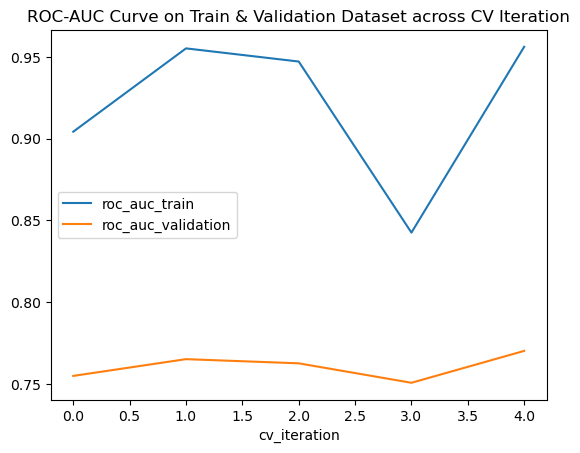

In [26]:
scores_lgb.plot(x="cv_iteration", y=["roc_auc_train", "roc_auc_validation"], title='ROC-AUC Curve on Train & Validation Dataset across CV Iteration')

<AxesSubplot: title={'center': 'Binary Logloss on Train & Validation Dataset across CV Iteration'}, xlabel='cv_iteration'>

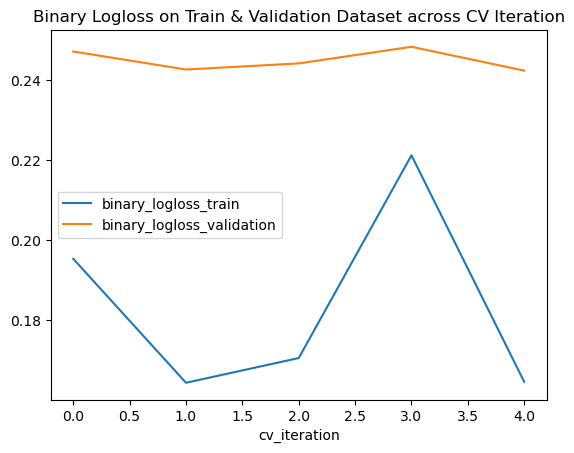

In [27]:
scores_lgb.plot(x="cv_iteration", y=["binary_logloss_train", "binary_logloss_validation"], title='Binary Logloss on Train & Validation Dataset across CV Iteration')

In [28]:
with open('best_params_lgb.pickle', 'wb') as f:
    pickle.dump(best_params_lgb, f)
    
with open('lgb_validation_results.pickle', 'wb') as f:
    pickle.dump(d_lgb, f)

### Fit on entire Data

In [29]:
#copying the best params
import copy
params = copy.deepcopy(best_params_lgb)

params['n_estimators'] = int(best_params_lgb['n_estimators'])
params['max_depth'] = int(best_params_lgb['max_depth'])
params['num_leaves'] = int(best_params_lgb['num_leaves'])

# initialize the model and fit entire X and y data
print("Fitting the data...")
lgbm_model = lgb.LGBMClassifier(**params)
lgbm_model.fit(X,y)

Fitting the data...


LGBMClassifier(colsample_bytree=0.34936564123480757,
               learning_rate=0.18570741799985363, max_depth=17,
               n_estimators=5000, num_leaves=400, reg_alpha=0.3868770270797042,
               reg_lambda=0.3973062362678611, subsample=0.5543133146726895)

Creating and saving the feature importance curve!


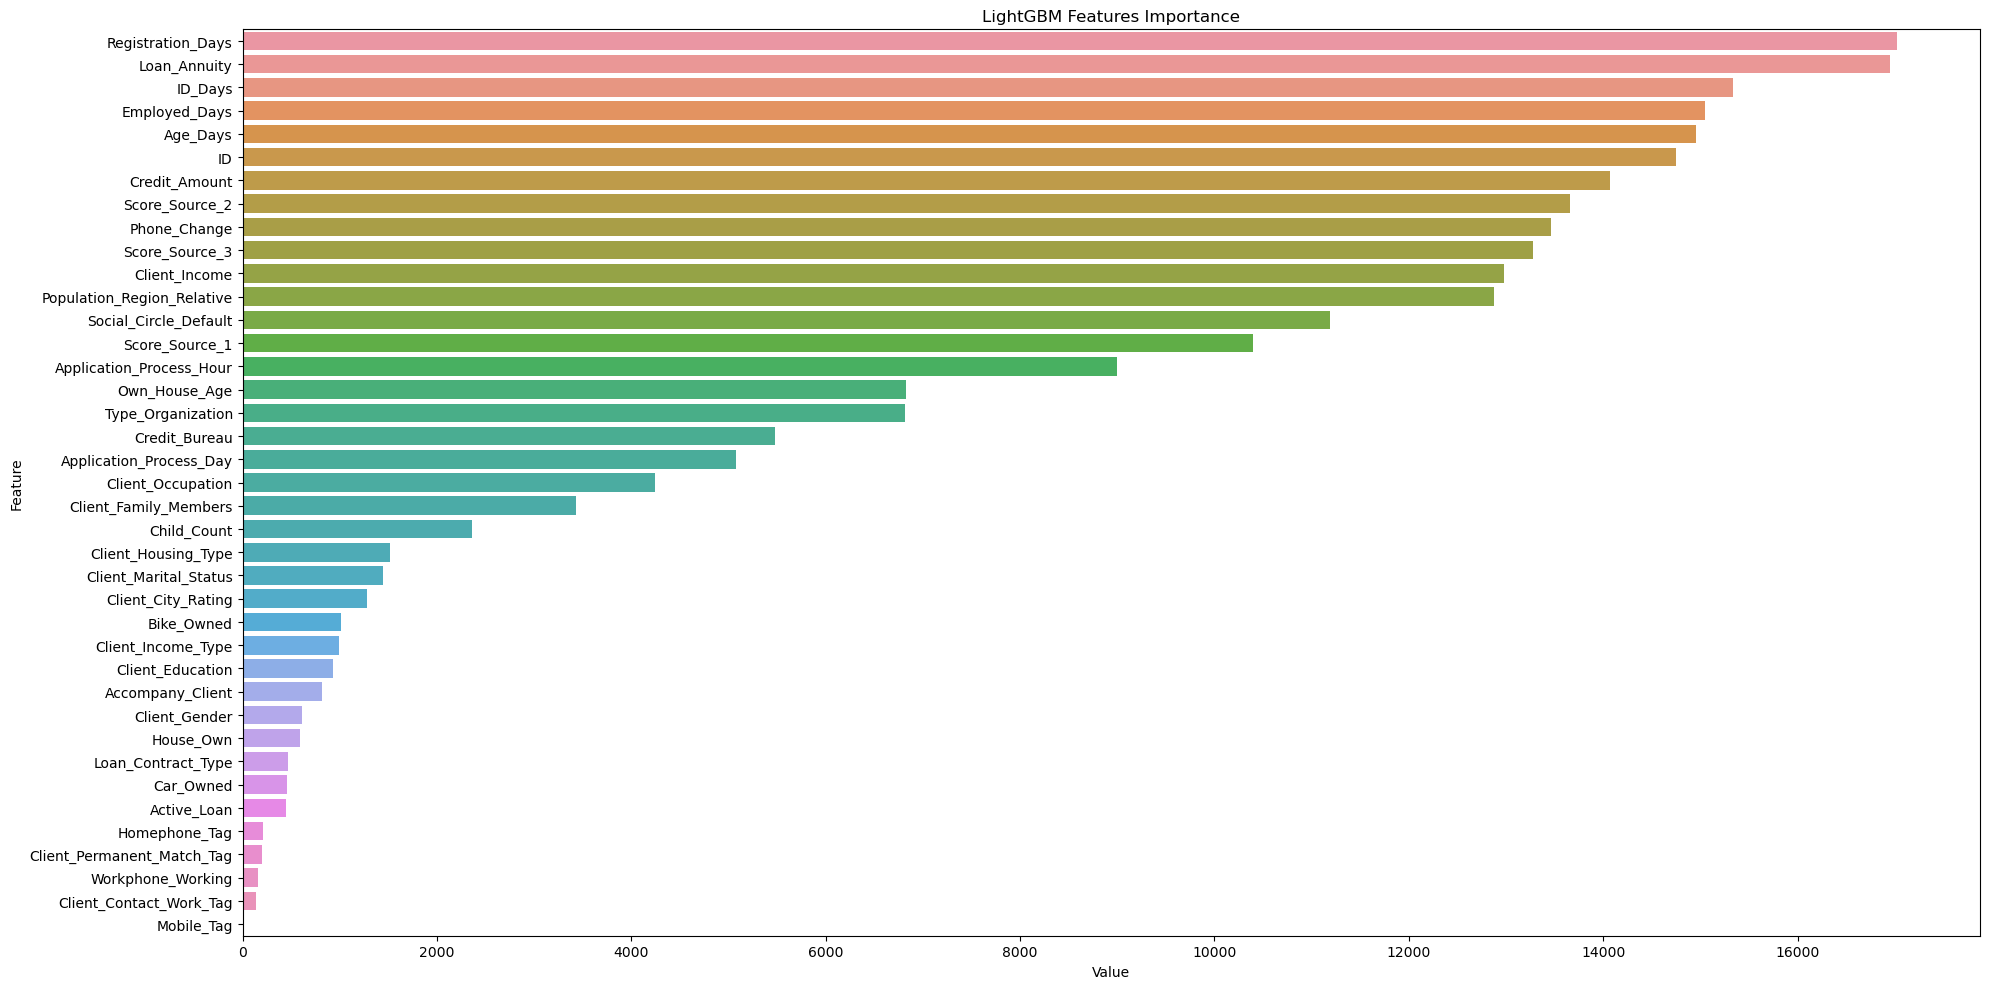

In [30]:
# Creating and saving feature importance curve
print("Creating and saving the feature importance curve!")
feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.tight_layout()

figure_name = f"lgbm_feature_importance_graph.png"
plt.savefig(figure_name)

In [32]:
#Save the model
print("Saving the model...")
filename = f"LightGBM_model.pickle"

with open(filename, 'wb') as f:
    pickle.dump(lgbm_model, f)

print("Saved")

Saving the model...
Saved


# XG Boost

In [80]:
d_xgb = {}

def objective_xgboost(params):
    """Performs Hyperparameter Optimization on LGBMRegressor"""
    
    for param in ['n_estimators','max_depth']:
        params[param] = int(params[param])
    
    model = XGBClassifier(**params, importance_type='gain', random_state=RANDOM_STATE)
    
    avg_score = 0
    
    for k, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        X_train, X_val, y_train, y_val = X.loc[train_idx,:], X.loc[valid_idx,:], y.loc[train_idx], y.loc[valid_idx]
        
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val,y_val)], eval_metric=['auc', 'logloss'],
                      early_stopping_rounds=50, verbose=False)
        
        # Make predictions on the validation set
        y_pred = model.predict(X_val)
            
        # Calculate ROC AUC score
        score = roc_auc_score(y_val, y_pred)
        avg_score += score/N_SPLITS
        
        d_xgb[k+1] = {}
        d_xgb[k+1]['params'] = model.get_params()
        # d_xgb[k+1]['best_iteration'] = model.best_iteration_
        # d_xgb[k+1]['best_score'] = model.best_score_
        d_xgb[k+1]['roc_auc_score'] = avg_score
        # d_xgb[k+1]['name'] = model.feature_name_
        # d_xgb[k+1]['importance'] = model.feature_importances_
        
    return {'loss': -avg_score, 'status': STATUS_OK}

In [81]:
# Run Bayesian optimization
trials_xgb = Trials()
best_xgb = fmin(fn=objective_xgboost, space=space_xgb, algo=tpe.suggest, max_evals=3, trials=trials_xgb)

# Retrieve best hyperparameters
best_params_xgb = space_eval(space_xgb, best_xgb)

100%|██████████| 3/3 [06:23<00:00, 127.86s/trial, best loss: -0.5207519215075889]


In [82]:
result_xgb = pd.DataFrame(d_xgb).T.reset_index().rename(columns={'index':'cv_iteration'})
result_xgb

,cv_iteration,params,roc_auc_score
0,1,"{'objective': 'binary:logistic', 'use_label_en...",0.103926
1,2,"{'objective': 'binary:logistic', 'use_label_en...",0.208531
2,3,"{'objective': 'binary:logistic', 'use_label_en...",0.312956
3,4,"{'objective': 'binary:logistic', 'use_label_en...",0.417191
4,5,"{'objective': 'binary:logistic', 'use_label_en...",0.520752


#### XG Boost results are very similar to LightGBM's. Hence, we will not explore this model further.

# SMOTE + Random Forest

In [45]:
train_non_encode = pd.read_parquet('training_data_non_encoded.parquet')

In [46]:
train_non_encode.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Client_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750.0,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,NaN,1,1,0,Sales,2.0,2.0,6.0,17.0,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250.0,1.0,0.0,1.0,NaN,0.0,15282.00,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,0.0,1,0,1,None,2.0,2.0,3.0,10.0,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000.0,0.0,0.0,1.0,0.0,1.0,59527.35,2788.20,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,16790.0,5102.0,NaN,331.0,NaN,1,0,0,Realty agents,2.0,2.0,4.0,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0
3,12188929,15750.0,0.0,0.0,1.0,1.0,0.0,53870.40,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195.0,365243.0,NaN,775.0,NaN,1,0,0,None,2.0,3.0,2.0,15.0,Yes,Yes,None,NaN,0.135182,0.631355,NaN,1700.0,3.0,0
4,12133385,33750.0,1.0,0.0,1.0,0.0,2.0,133988.40,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366.0,2977.0,5516.0,4043.0,6.0,1,0,0,Laborers,4.0,1.0,3.0,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0


0    112011
1      9845
Name: Default, dtype: int64


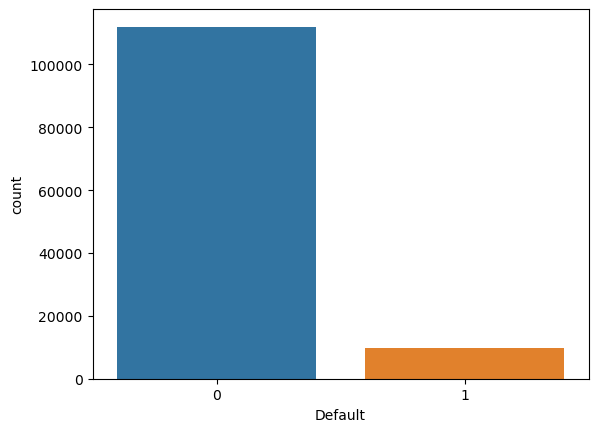

In [47]:
ax = sns.countplot(x=TARGET, data=train_non_encode)
print(train_non_encode[TARGET].value_counts())

In [48]:
## missing data
def missing_values(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_cols = missing_data[missing_data['Total']>0]
    print(f"Your Dataframe has {df.shape[1]} columns, out of which {missing_cols.shape[0]}")
    missing_data.head(20).style.background_gradient(cmap='Greens') #'Reds'
    return missing_data

## missing data
missing_df = missing_values(train_non_encode)

Your Dataframe has 40 columns, out of which 33


In [49]:
missing_df

,Total,Percent
Own_House_Age,80095,0.657292
Score_Source_1,68835,0.564888
Social_Circle_Default,61928,0.508206
Client_Occupation,41435,0.340032
Score_Source_3,26922,0.220933
Type_Organization,24694,0.202649
Credit_Bureau,18540,0.152147
ID_Days,5985,0.049115
Score_Source_2,5686,0.046662
Population_Region_Relative,4868,0.039949


In [50]:
miss_cols = list(missing_df[missing_df['Percent']!=0].index)

miss_cat_cols = [c for c in miss_cols if train_non_encode[c].dtypes=='O']
miss_num_cols = [c for c in miss_cols if train_non_encode[c].dtypes!='O']

for c in miss_cat_cols:
    train_non_encode[c].fillna(train_non_encode[c].mode()[0], inplace=True)
    
for c in miss_num_cols:
    train_non_encode[c].fillna(train_non_encode[c].median(), inplace=True)

In [51]:
## missing data
missing_values(train_non_encode)

Your Dataframe has 40 columns, out of which 0


,Total,Percent
ID,0,0.0
Client_Income,0,0.0
Mobile_Tag,0,0.0
Homephone_Tag,0,0.0
Workphone_Working,0,0.0
Client_Occupation,0,0.0
Client_Family_Members,0,0.0
Client_City_Rating,0,0.0
Application_Process_Day,0,0.0
Application_Process_Hour,0,0.0


In [52]:
train_encoded_smote = train_non_encode.copy()

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train_encoded_smote:
    if train_encoded_smote[col].dtype == 'object':
        # Train on the training data
        le.fit(train_encoded_smote[col])
        # Transform both training and testing data
        train_encoded_smote[col] = le.transform(train_encoded_smote[col])
#         test[col] = le.transform(test[col])
        
        # Keep track of how many columns were label encoded
        le_count += 1
            
print('%d columns were label encoded.' % le_count)

print('Training Features shape: ', train_encoded_smote.shape)
# print('Testing Features shape: ', test.shape)

11 columns were label encoded.
Training Features shape:  (121856, 40)


In [53]:
X_sm = train_encoded_smote.iloc[:, :-1]
y_sm = train_encoded_smote[TARGET]

X_sm.shape, y_sm.shape

((121856, 39), (121856,))

In [54]:
# the function that we will use to better evaluate the model
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f1: {}".format(f1_score(true_value, pred)))

# splitting data into training and test set
X_train, X_valid, y_train, y_valid = train_test_split(X_sm, y_sm, random_state=RANDOM_STATE, test_size=0.2)

classifier = RandomForestClassifier

# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=RANDOM_STATE),
                                   classifier(random_state=RANDOM_STATE))

smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_valid)

#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y_sm)))

X_smote, y_smote = SMOTE().fit_resample(X_sm, y_sm)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0: 112011, 1: 9845})
SMOTE data distribution: Counter({0: 112011, 1: 112011})


In [55]:
print("Confusion Matrix: ")
print(confusion_matrix(y_valid, smote_prediction))

print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_valid, y_valid)))

print_results("\nSMOTE + RandomForest classification", y_valid, smote_prediction)

Confusion Matrix: 
[[22392    33]
 [ 1703   244]]

SMOTE Pipeline Score 0.9287707204989332

SMOTE + RandomForest classification
accuracy: 0.9287707204989332
precision: 0.8808664259927798
recall: 0.12532100667693888
f1: 0.21942446043165464


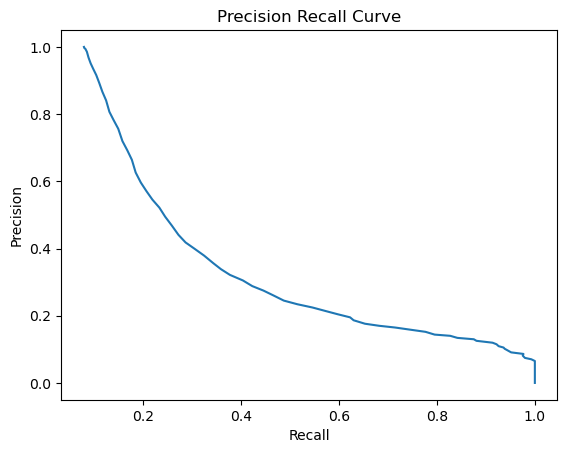

In [58]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = smote_pipeline.predict_proba(X_valid)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

**Inference**

1. We can improve this model by doing hyperparameter optimization using Grid/RandomizedSearch CV or any other method.

2. Due to time constraint, I keeping the SMOTE algorithm as an open ended, which can be improved further by proper hyperparameter optimization.

3. Our LightGBM model working well as compared to Random Forest + SMOTE, and I will use LightGBM model which is optimised using HyperOpt Bayesian search for predicting the test results.

# Prediction

In [59]:
with open('LightGBM_model.pickle', 'rb') as f:
    model_loaded = pickle.load(f)

In [60]:
model_loaded

LGBMClassifier(colsample_bytree=0.34936564123480757,
               learning_rate=0.18570741799985363, max_depth=17,
               n_estimators=5000, num_leaves=400, reg_alpha=0.3868770270797042,
               reg_lambda=0.3973062362678611, subsample=0.5543133146726895)

In [65]:
y_pred_lgb = model_loaded.predict(test_encode)

In [71]:
test_prediction = pd.concat([test_encode, pd.Series(y_pred_lgb)], axis=1)
test_prediction.rename(columns={0:'Default_Prediction'}, inplace=True)

In [78]:
test_prediction['Default_Prediction'].value_counts()

0    79681
1     1219
Name: Default_Prediction, dtype: int64

In [79]:
test_prediction.to_parquet('test_prediction.parquet', index=False)

# END